In [1]:
import matplotlib.pyplot as plt 
import matplotlib
import pandas as pd 
import numpy as np 
import os
import shutil

In [2]:
# создание и удаление директорий  
def create_dir(path: str):
    if os.path.isdir(path):
        shutil.rmtree(path, ignore_errors=True)
        os.mkdir(path)
    else:
        os.mkdir(path)

# нахождение всех вложенных директорий 
def find_directories_data_folder(data_folder: str) -> list:
    dir_list = []
    for i in os.listdir(data_folder):
        if os.path.isdir(f'{data_folder}/{i}'):
            dir_list.append(f'{i}')
    return dir_list

# нахождение всех вложенных файлов
def find_files_in_data_folder(data_folder: str) -> list:
    file_list = []
    for i in os.listdir(data_folder):
        if os.path.isfile(f'{data_folder}/{i}'):
            file_list.append(f'{i}')
    return file_list

# нахождение всех файлов в директориях
def find_files_in_directories(data_folder: str) -> list:
    dir_list = find_directories_data_folder(data_folder=data_folder)
    dir_and_files_dict = []
    for i in dir_list:
        onlyfiles = [int(f.replace('.data','')) for f in os.listdir(os.path.abspath(data_folder + '\\' +  i)) if os.path.isfile(os.path.join(data_folder +'\\' +   i, f))]
        dir_and_files_dict.append(onlyfiles)
    return dir_and_files_dict

# составление списка header файлов по имющимся файлам в папке
def find_header(data_folder: str)-> list:
    dir_list = find_directories_data_folder(data_folder=data_folder)
    files_list = find_files_in_data_folder(data_folder=data_folder)
    header_list = []
    for i in dir_list:
        if f'{i}.header' in files_list:
            header_list.append(f'{i}.header')
    return header_list

# считываем данные об измерениях из header файлов
def get_all_measurments_info(data_folder)-> dict:
    header_list = find_header(data_folder=data_folder)
    splite_line = '______________________________________________________'
    all_measurments_info = {}
    for i in header_list:
        with open(f'{data_folder}\{i}') as f:
            header_lines = []
            for k in f.readlines()[:-2]:
                header_lines.append(k.replace('\n', ''))
            single_contact_info = {}
            for j in range(len(header_lines)):
                if header_lines[j] == splite_line:
                    number, *m_type = header_lines[j + 3].split()
                    file_path = header_lines[j + 8].split()[-1]
                    single_contact_info[int(number)] = {'type': ' '.join(m_type), 'file_path': file_path}
                else:
                    continue
        all_measurments_info[i.replace('.header', '')] =  single_contact_info
    return all_measurments_info

# получение дискретной палитры цветов
def get_colors_from_cmap(cmap_name: str, lenght: int) -> list:
    cmap = plt.get_cmap(cmap_name)
    individual_colors = [cmap(i / lenght) for i in range(lenght)]
    return individual_colors

# поэтапное рисование графика 
def draw_line_by_step(ax, data_V, data_I):
    for i in range(len(data_V)-1):
        ax.plot([data_V[i], data_V[i+1]], np.abs([data_I[i], data_I[i+1]]), solid_capstyle='round')

# раскашивание линий в градиент
def colorize_line(ax: matplotlib.axes, colormap_name: str, lenght: int):
    colors = get_colors_from_cmap(colormap_name, lenght)
    lines = ax.get_lines()
    for i in range(lenght-1):
        lines[i].set_color(colors[i])

# получение данных с указанных фалов и директорий
def get_single_data_from_path(data_folder: str, file_path: str) -> pd.DataFrame:
    single_data_path = os.path.abspath(data_folder + '\\' + file_path)
    single_df = pd.read_csv(single_data_path, delimiter='   ', skiprows=16, engine='python', header=None, encoding='ISO-8859-1').astype(np.float32)
    single_df.rename(columns = {0: 'voltage', 1: 'current', 2: 'resistance'}, inplace=True)
    return single_df

# рисование одного графикаи змерения типа DC IV 
def draw_single_DC_IV(data_V: pd.Series, data_I: pd.Series, fig: matplotlib.figure, ax: matplotlib.axes):
    data_len = len(data_V)
    draw_line_by_step(ax, data_V, data_I)
    colorize_line(ax, 'inferno', data_len)
    ax.set_yscale('log')
    ax.grid(which='major', linewidth = 0.6)
    ax.grid(which='minor', linewidth = 0.2)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.inferno, norm=plt.Normalize(vmin=0, vmax=data_len))
    cbar = fig.colorbar(sm)
    cbar.set_ticks([0, data_len])
    cbar.set_ticklabels(['start','end'])
    cbar.set_label('sequence of measurements', size = 15)


def draw_all_DC_IV_from_data_folder(data_folder: str):
    all_info = get_all_measurments_info(data_folder=data_folder)
    global_graph_folder = '_'.join([data_folder, 'graphs'])
    create_dir(global_graph_folder)
    for i in list((all_info.keys())):
        local_graph_folder = '\\'.join([global_graph_folder, i]) 
        create_dir(local_graph_folder)
        for j in list(all_info[i].keys()):
            if all_info[i][j]['type'] == 'DC IV':
                fig, ax = plt.subplots(figsize = [10,5])
                data = get_single_data_from_path(data_folder, all_info[i][j]['file_path'])
                I = data['current']
                V = data['voltage']
                draw_single_DC_IV(V, I, fig, ax)
                plt.savefig(local_graph_folder + '\\' + str(j) + '.png', bbox_inches = 'tight', dpi = 200)
                plt.clf()

C:\Users\Никита Жидков\AppData\Local\Temp\ipykernel_13400\2706820689.py:99: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)
C:\Users\Никита Жидков\AppData\Local\Temp\ipykernel_13400\2706820689.py:99: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)
C:\Users\Никита Жидков\AppData\Local\Temp\ipykernel_13400\2706820689.py:99: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to 

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Никита Жидков\\Documents\\GitHub\\hBN_analysis\\hBN_1_3\\test\\9.data'

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

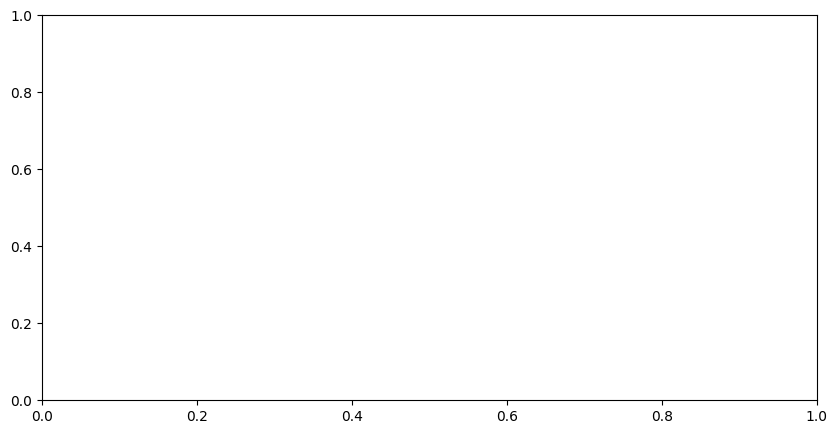

In [3]:
draw_all_DC_IV_from_data_folder('hBN_1_3')